In [1]:
import cv2

In [2]:
import tensorflow

In [3]:
import tensorflow as tf

In [59]:
import os
import sys
import random

import numpy as np
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
import cv2

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import os

TRAIN_PATH = './U_NET/train/'
TEST_PATH = './U_NET/validation/'
IMG_HEIGHT = 128
IMG_WIDTH  = 128

In [60]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]


In [61]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH,3), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [62]:
for i, id_ in enumerate(train_ids):
    path = TRAIN_PATH+"{}/images/{}".format(id_, id_)
    img = cv2.imread(path+".png", 1)
    img = cv2.resize(img, (IMG_HEIGHT,IMG_WIDTH ))
    X_train[i]=img
    
    label = np.zeros((IMG_HEIGHT,IMG_WIDTH, 1))
    path2 = TRAIN_PATH+"{}/masks/".format(id_)
    for mask_file in next(os.walk(path2))[2]:
        mask_ = cv2.imread(path2+mask_file, 0)
        mask_ = cv2.resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
        mask_ = np.expand_dims(mask_, axis=-1)
        label = np.maximum(label, mask_)
        Y_train[i]=label

In [64]:
print(X_train.shape)
print(Y_train.shape)

(670, 128, 128, 3)
(670, 128, 128, 1)


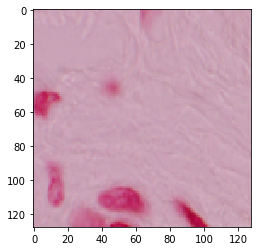

In [65]:
ymg = X_train[4]
plt.imshow(ymg)
plt.show()

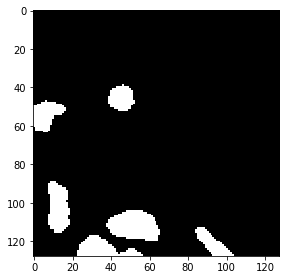

In [66]:
test_image = Y_train[4][:,:,0]
imshow(test_image)
plt.show()

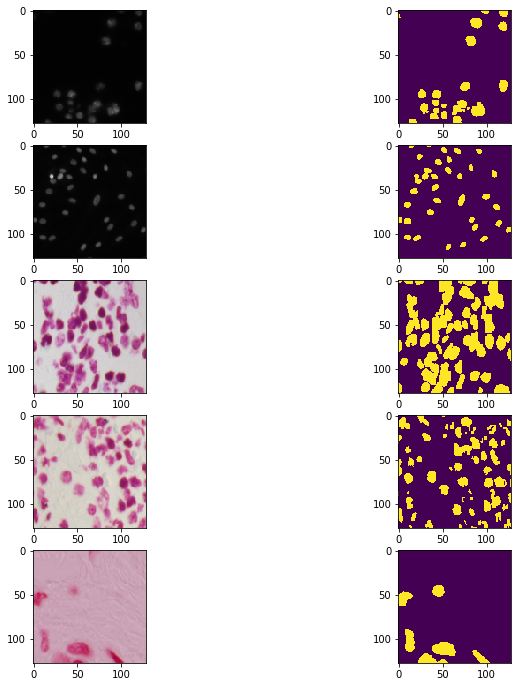

In [67]:
fig = plt.figure(figsize=(12,12))
rows = 5
columns = 2
count =0 
c=0
for i in range(1,rows*columns +1):
    fig.add_subplot(rows,columns,i)
    if count%2==0:
        plt.imshow(X_train[c])
    else :
        plt.imshow(Y_train[c][:,:,0])
        c=c+1
    count =count +1

    

In [68]:
from skimage.color import rgb2gray
X_train_ = rgb2gray(X_train)
print(X_train.shape)

(670, 128, 128, 3)


In [69]:
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale = 1./255,
                              rotation_range=40,
                              height_shift_range = 0.2,
                              width_shift_range = 0.2,
                              zoom_range = 0.2,
                              horizontal_flip = True,
                              fill_mode='nearest')

val_gen = ImageDataGenerator(rescale=1./255)

In [70]:
from sklearn.model_selection import train_test_split

xtrain, xvalid , ytrain, yvalid = train_test_split(X_train, Y_train, test_size=0.2)

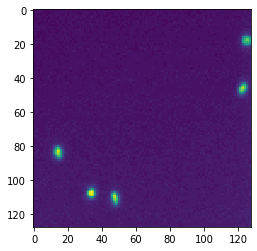

In [71]:
plt.imshow(xtrain[10][:,:,0])

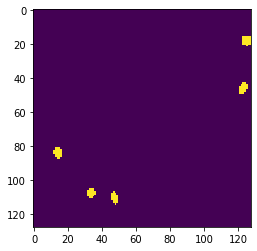

In [72]:
plt.imshow(ytrain[10][:,:,0])

In [73]:
import tensorflow as tf 
from tensorflow import keras

In [74]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

In [75]:
IMG_CHANNELS = 3
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

In [76]:
c1 = Conv2D(16, (3,3), activation = 'elu',kernel_initializer='he_normal', padding ='same')(s)
c1 = Conv2D(16, (3,3), activation = 'elu',kernel_initializer='he_normal', padding ='same')(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3,3), activation = 'elu',kernel_initializer='he_normal', padding ='same')(p1)
c2 = Conv2D(32, (3,3), activation = 'elu',kernel_initializer='he_normal', padding ='same')(c2)
p2 = MaxPooling2D((2, 2)) (c2)


c3 = Conv2D(64, (3,3), activation = 'elu',kernel_initializer='he_normal', padding ='same')(p2)
c3 = Conv2D(64, (3,3), activation = 'elu',kernel_initializer='he_normal', padding ='same')(c3)
p3 = MaxPooling2D((2, 2)) (c3)


c4 = Conv2D(128, (3,3), activation = 'elu',kernel_initializer='he_normal', padding ='same')(p3)
c4 = Conv2D(128, (3,3), activation = 'elu',kernel_initializer='he_normal', padding ='same')(c4)
p4 = MaxPooling2D((2, 2)) (c4)


c5 = Conv2D(256, (3,3), activation = 'elu',kernel_initializer='he_normal', padding ='same')(p4)
c5 = Conv2D(256, (3,3), activation = 'elu',kernel_initializer='he_normal', padding ='same')(c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6,c4])
c6 = Conv2D(128, (3,3), activation = 'elu',kernel_initializer='he_normal', padding ='same')(u6)
c6 = Conv2D(128, (3,3), activation = 'elu',kernel_initializer='he_normal', padding ='same')(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7,c3])
c7 = Conv2D(64, (3,3), activation = 'elu',kernel_initializer='he_normal', padding ='same')(u7)
c7 = Conv2D(64, (3,3), activation = 'elu',kernel_initializer='he_normal', padding ='same')(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8,c2])
c8 = Conv2D(32, (3,3), activation = 'elu',kernel_initializer='he_normal', padding ='same')(u8)
c8 = Conv2D(32, (3,3), activation = 'elu',kernel_initializer='he_normal', padding ='same')(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9,c1],axis=3)
c9 = Conv2D(16, (3,3), activation = 'elu',kernel_initializer='he_normal', padding ='same')(u9)
c9 = Conv2D(16, (3,3), activation = 'elu',kernel_initializer='he_normal', padding ='same')(c9)

outputs = Conv2D(1, (1,1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy',metrics =['accuracy'])
model.summary()



Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 128, 128, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 128, 128, 16) 448         lambda_4[0][0]                   
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 128, 128, 16) 2320        conv2d_58[0][0]                  
____________________________________________________________________________________________

In [55]:
path = 'ImageSegmentation.h5'
checkpoint = ModelCheckpoint(path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)


In [77]:
results = model.fit(xtrain, ytrain,
                    validation_data = [xvalid , yvalid],
                    batch_size=16, epochs=10,
                    callbacks=[earlystop, checkpoint])

Train on 536 samples, validate on 134 samples
Epoch 1/10
536/536 [==============================] - 7s 13ms/step - loss: 0.3053 - accuracy: 0.8738 - val_loss: 0.1969 - val_accuracy: 0.9154

Epoch 00001: val_loss improved from inf to 0.19689, saving model to ImageSegmentation.h5
Epoch 2/10
536/536 [==============================] - 5s 9ms/step - loss: 0.1664 - accuracy: 0.9339 - val_loss: 0.1529 - val_accuracy: 0.9390

Epoch 00002: val_loss improved from 0.19689 to 0.15288, saving model to ImageSegmentation.h5
Epoch 3/10
536/536 [==============================] - 5s 8ms/step - loss: 0.1267 - accuracy: 0.9503 - val_loss: 0.1080 - val_accuracy: 0.9581

Epoch 00003: val_loss improved from 0.15288 to 0.10798, saving model to ImageSegmentation.h5
Epoch 4/10
536/536 [==============================] - 5s 9ms/step - loss: 0.1059 - accuracy: 0.9590 - val_loss: 0.0994 - val_accuracy: 0.9623

Epoch 00004: val_loss improved from 0.10798 to 0.09942, saving model to ImageSegmentation.h5
Epoch 5/10
53

In [78]:
predict_train = model.predict(xtrain)
predict_valid = model.predict(xvalid)
pred_train_t = (predict_train > 0.5).astype(np.uint8)
pred_val_t = (predict_valid > 0.5).astype(np.uint8)

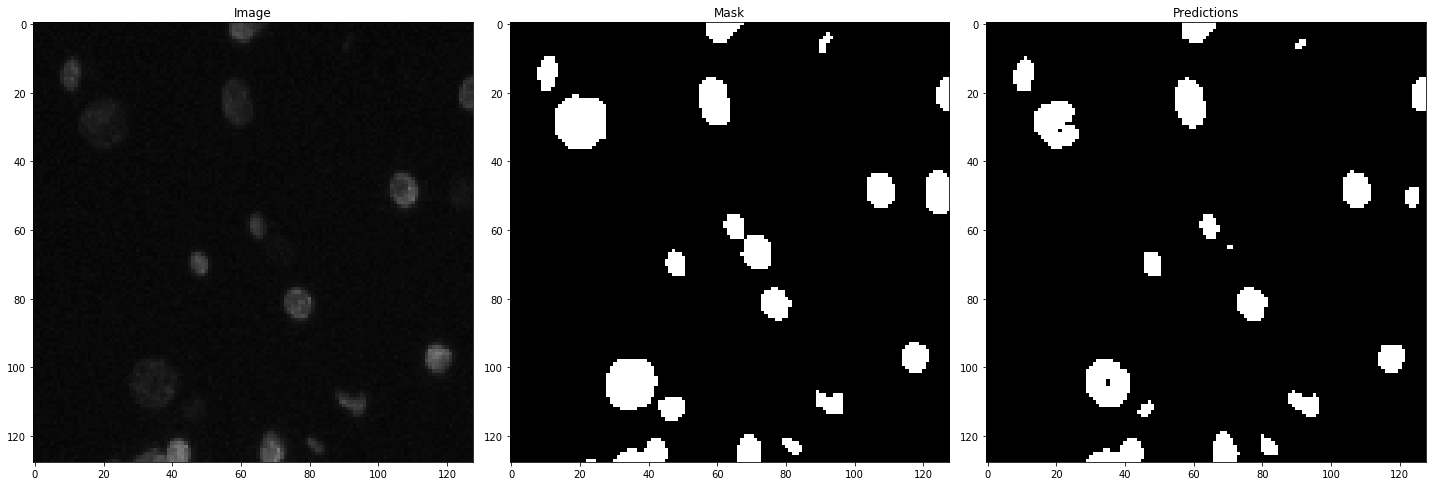

In [79]:
# Ploting our predicted masks
ix = random.randint(0, 535)
plt.figure(figsize=(20,20))

# Our original training image
plt.subplot(131)
imshow(xtrain[ix])
plt.title("Image")

# Our original combined mask  
plt.subplot(132)
imshow(np.squeeze(ytrain[ix]))
plt.title("Mask")

# The mask our U-Net model predicts
plt.subplot(133)
imshow(np.squeeze(pred_train_t[ix] > 0.5))
plt.title("Predictions")
plt.show()

C:\Users\91727\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


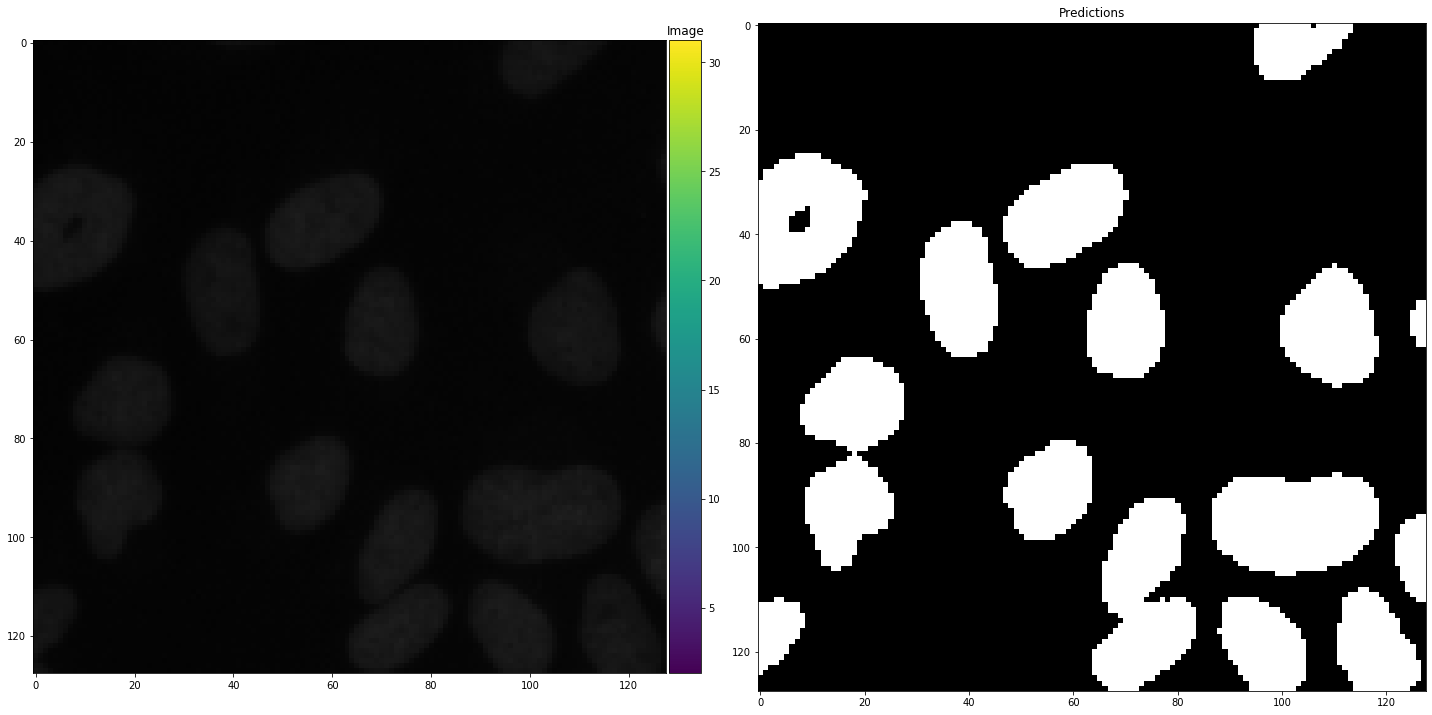

In [82]:
# Ploting our predicted masks
ix = random.randint(0,133)
plt.figure(figsize=(20,20))

# Our original training image
plt.subplot(121)
imshow(xvalid[ix])
plt.title("Image")

# The mask our U-Net model predicts
plt.subplot(122)
imshow(np.squeeze(pred_val_t[ix] > 0.5))
plt.title("Predictions")
plt.show()